In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [ ]:
# Load the sentiment data
sentiment_data = pd.read_csv(r"C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final2\sentimentAnalysis.csv")
print(f"Dataset shape: {sentiment_data.shape}")
print(f"Columns: {sentiment_data.columns.tolist()}")
sentiment_data.head()

Dataset shape: (40000, 4)
Columns: ['tweet_id', 'sentiment', 'author', 'content']


tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...

In [5]:
# Check for missing values
missing_values = sentiment_data.isnull().sum()
plt.figure(figsize=(10, 6))

if not missing_values[missing_values > 0].empty:
    missing_values[missing_values > 0].plot(kind='bar')
    plt.title('Missing Values in Dataset')
    plt.xlabel('Columns')
    plt.ylabel('Count of Missing Values')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

# Basic statistics
print("\nBasic Statistics:")
print(sentiment_data.describe())

print("\nData Types:")
print(sentiment_data.dtypes)

No missing values found in the dataset.

Basic Statistics:
           tweet_id
count  4.000000e+04
mean   1.845184e+09
std    1.188579e+08
min    1.693956e+09
25%    1.751431e+09
50%    1.855443e+09
75%    1.962781e+09
max    1.966441e+09

Data Types:
tweet_id      int64
sentiment    object
author       object
content      object
dtype: object


<Figure size 1000x600 with 0 Axes>

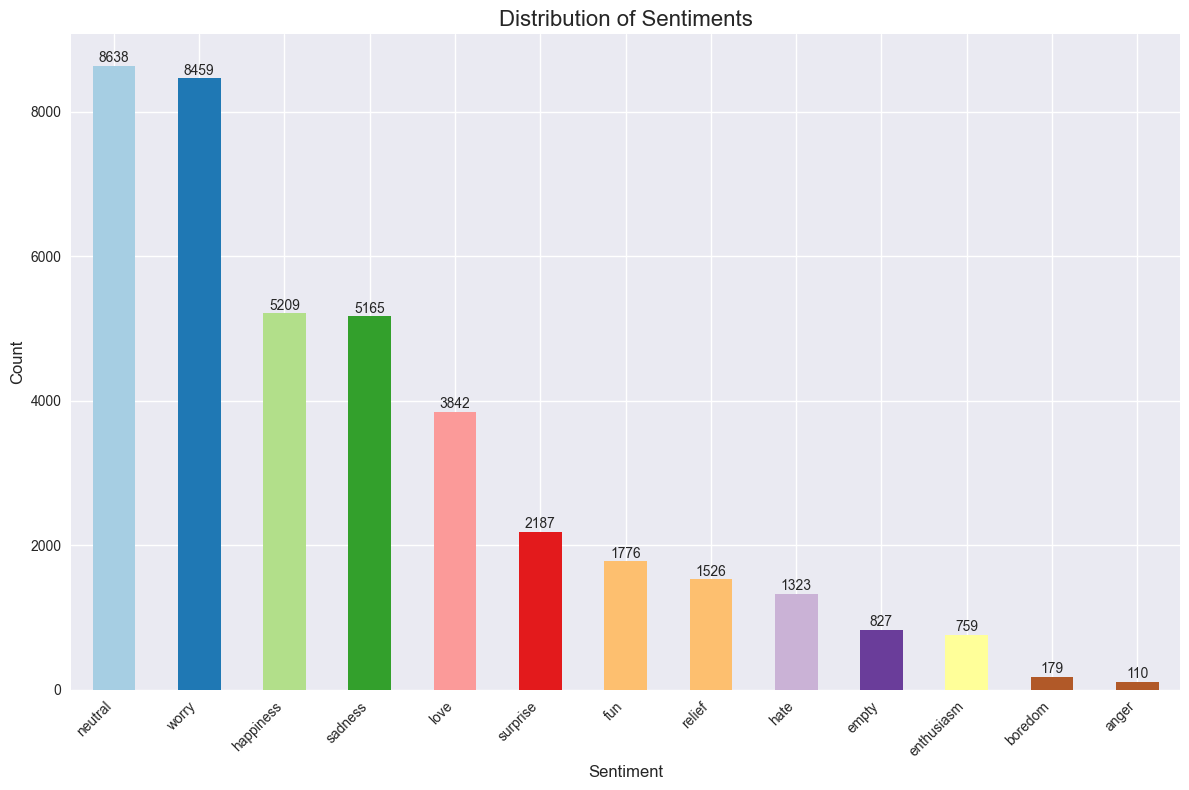

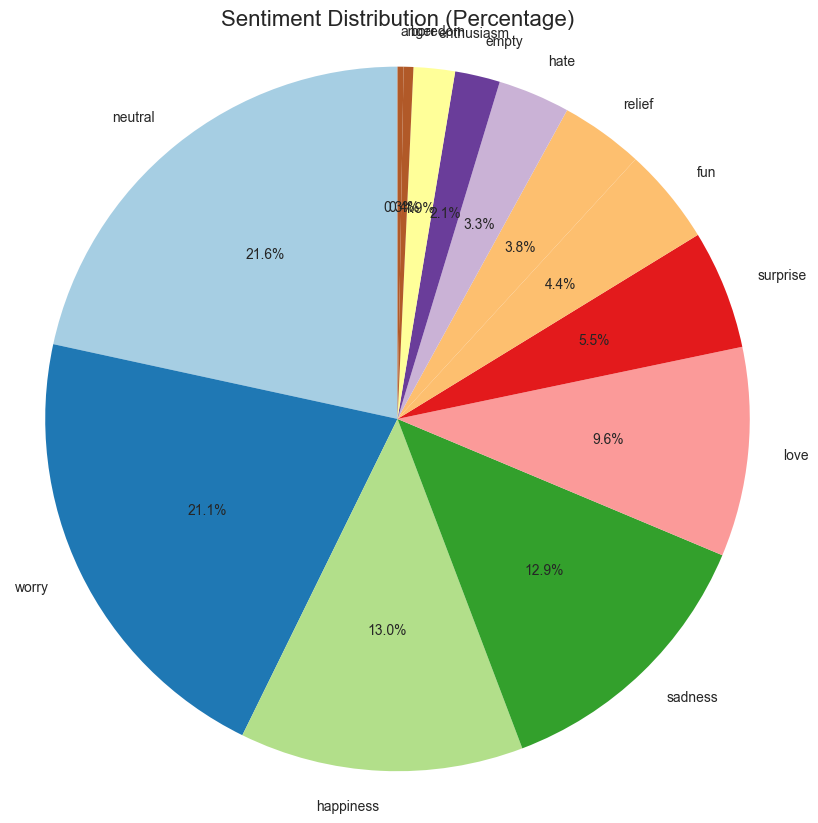

In [6]:
# Sentiment distribution
plt.figure(figsize=(12, 8))
sentiment_counts = sentiment_data['sentiment'].value_counts()
colors = plt.cm.Paired(np.linspace(0, 1, len(sentiment_counts)))

ax = sentiment_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Sentiments', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Pie chart for sentiment distribution
plt.figure(figsize=(10, 10))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Sentiment Distribution (Percentage)', fontsize=16)
plt.axis('equal')
plt.show()

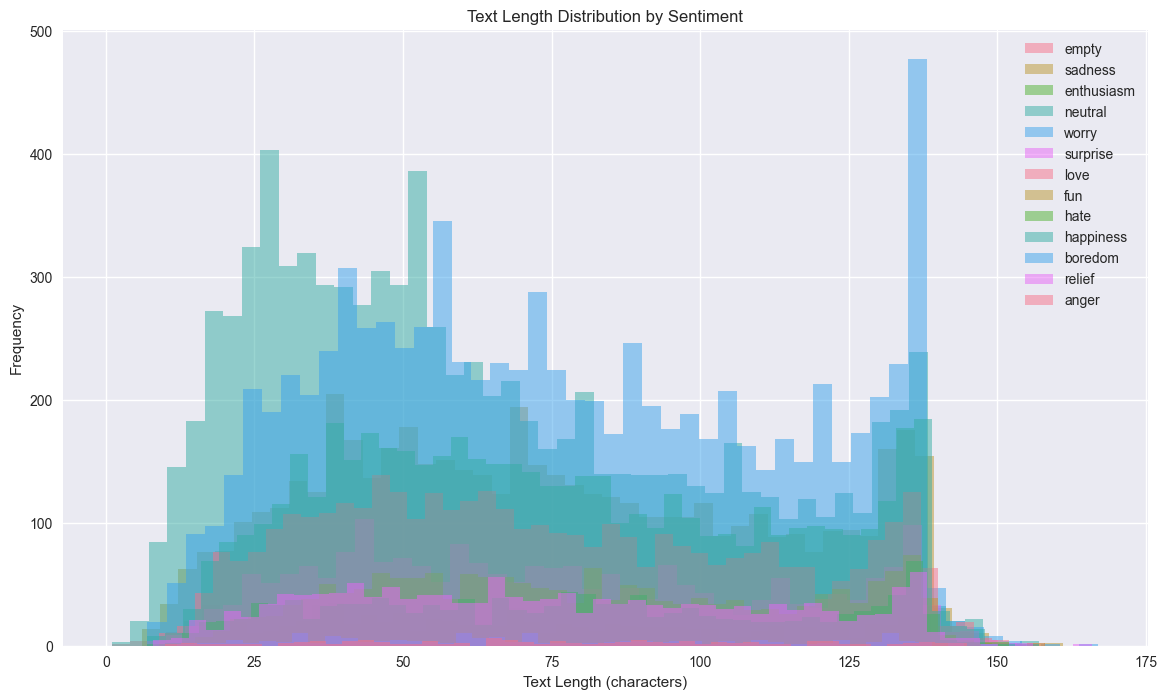

<Figure size 1400x800 with 0 Axes>

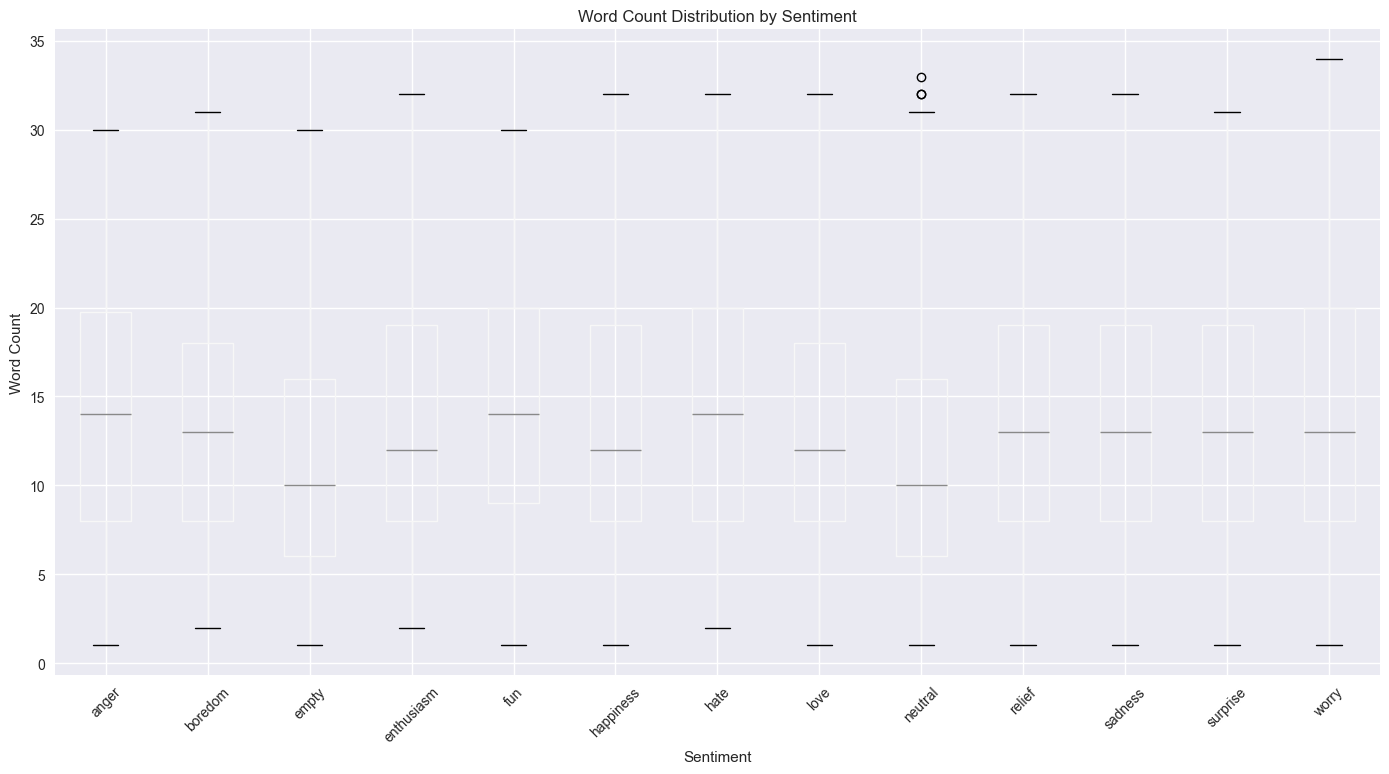

In [7]:
# Text length analysis
sentiment_data['text_length'] = sentiment_data['content'].apply(len)
sentiment_data['word_count'] = sentiment_data['content'].apply(lambda x: len(str(x).split()))

# Plot text length distribution by sentiment
plt.figure(figsize=(14, 8))
for i, sentiment in enumerate(sentiment_data['sentiment'].unique()):
    subset = sentiment_data[sentiment_data['sentiment'] == sentiment]
    plt.hist(subset['text_length'], bins=50, alpha=0.5, label=sentiment)

plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Sentiment')
plt.legend()
plt.show()

# Box plot of word count by sentiment
plt.figure(figsize=(14, 8))
sentiment_data.boxplot(column='word_count', by='sentiment', figsize=(14, 8))
plt.xticks(rotation=45)
plt.title('Word Count Distribution by Sentiment')
plt.suptitle('')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

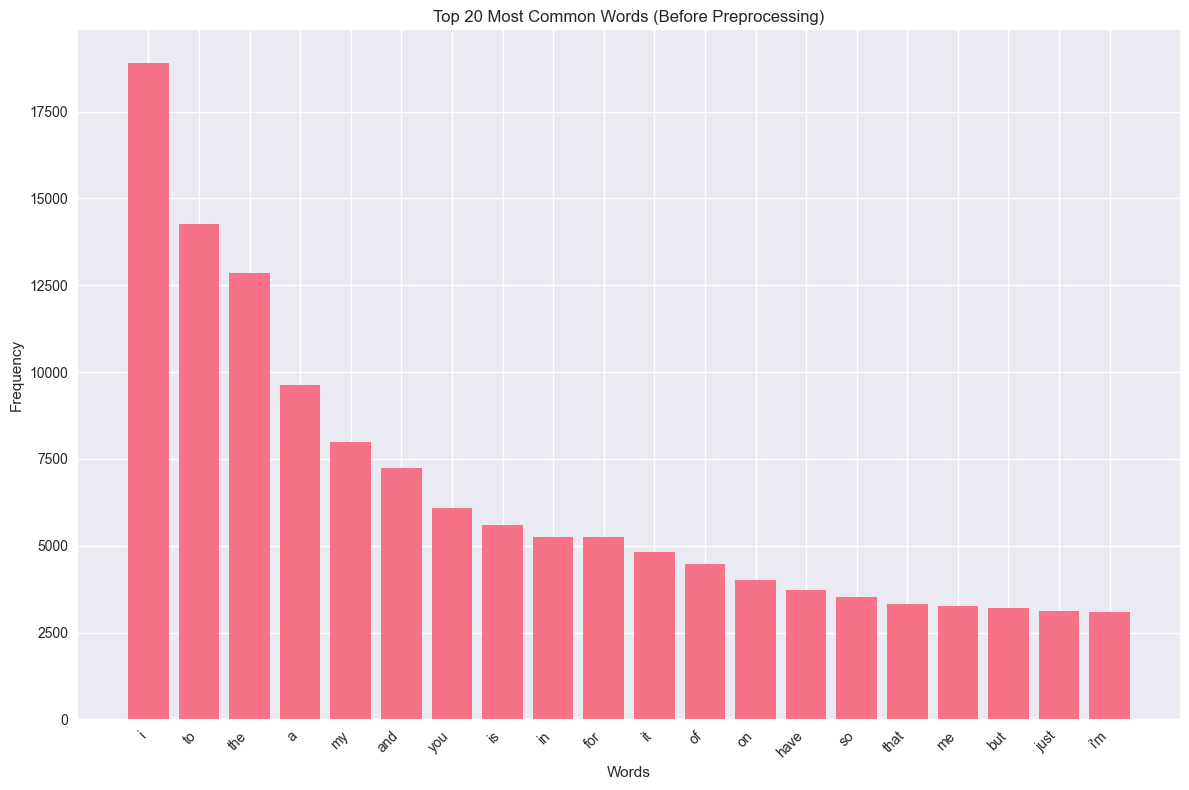

In [8]:
# Most common words overall
from collections import Counter

def get_top_words(text_series, n=20):
    words = ' '.join(text_series).lower().split()
    return Counter(words).most_common(n)

top_words = get_top_words(sentiment_data['content'])

plt.figure(figsize=(12, 8))
words, counts = zip(*top_words)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words (Before Preprocessing)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

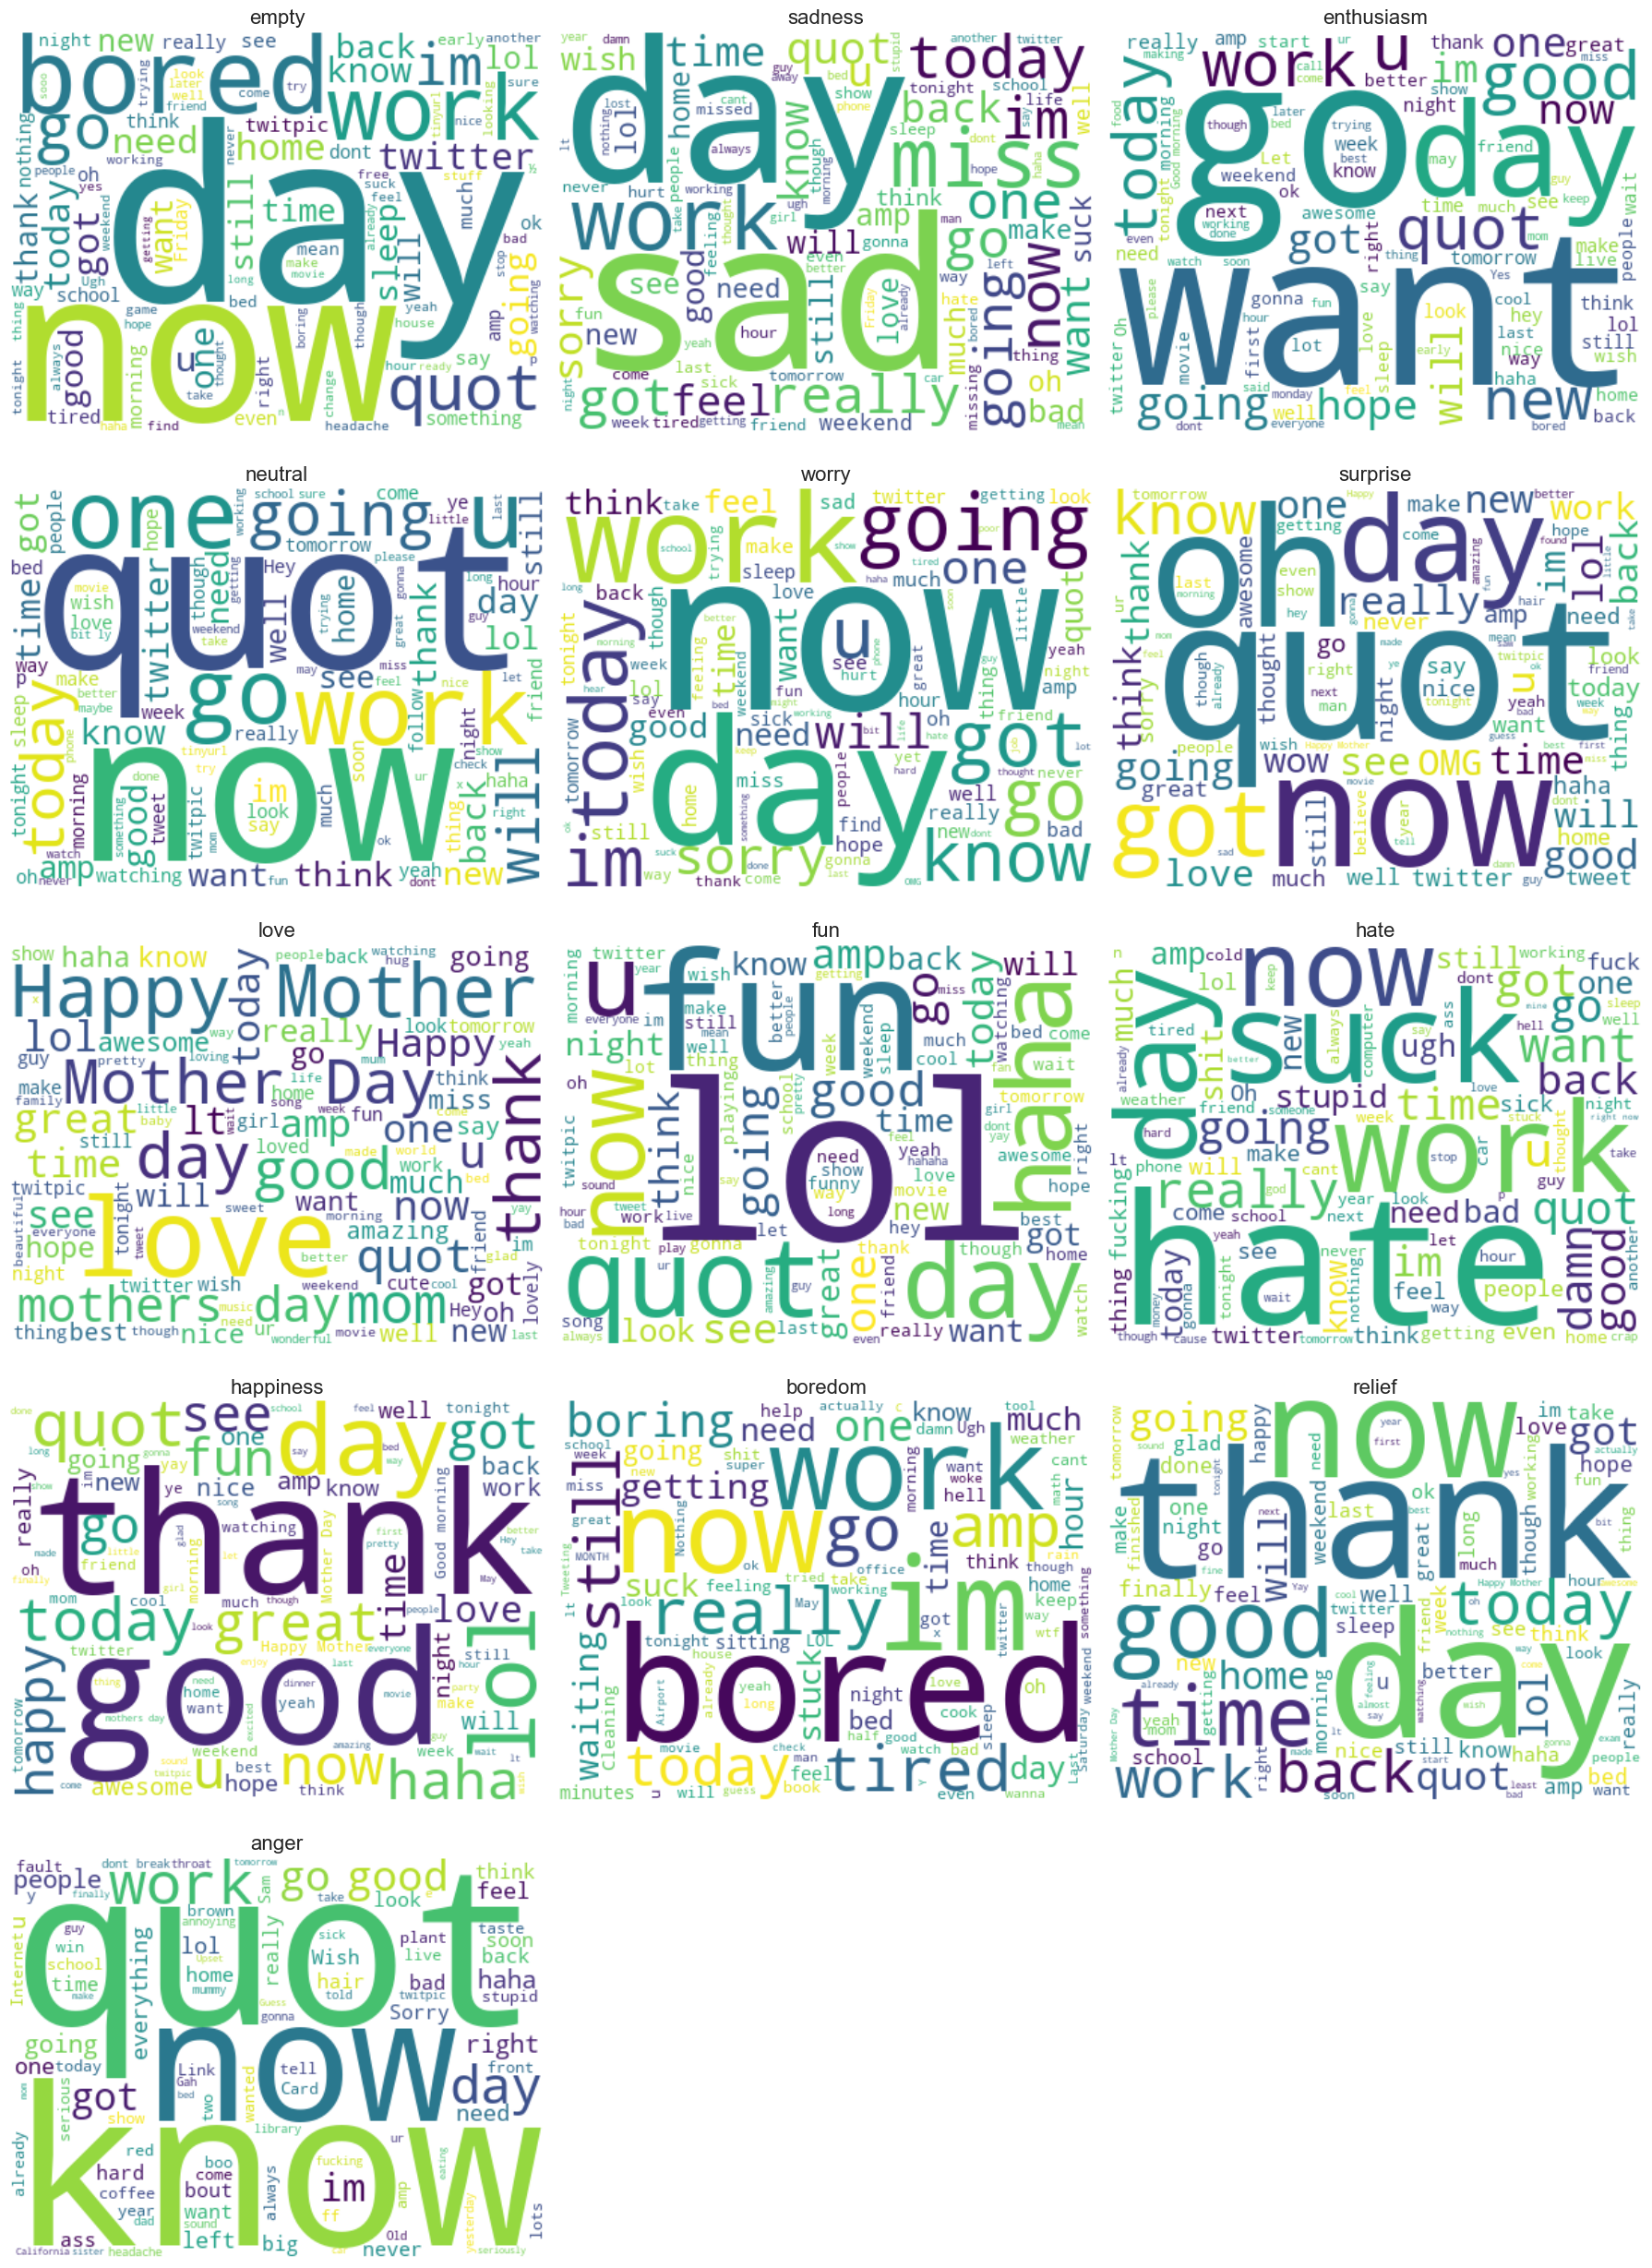

In [10]:
from math import ceil
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get unique sentiments
sentiments = sentiment_data['sentiment'].unique()
num_sentiments = len(sentiments)

# Calculate number of rows and columns
cols = 3
rows = ceil(num_sentiments / cols)

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.ravel()  # Flatten to 1D array for easier indexing

# Generate word clouds
for idx, sentiment in enumerate(sentiments):
    text = ' '.join(sentiment_data[sentiment_data['sentiment'] == sentiment]['content'].dropna())
    wordcloud = WordCloud(width=400, height=300, background_color='white', 
                          colormap='viridis', max_words=100).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment}', fontsize=16)
    axes[idx].axis('off')

# Hide unused axes
for idx in range(num_sentiments, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [11]:
def enhanced_clean_text(text):
    """Enhanced text cleaning function"""
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply text cleaning
sentiment_data['clean_content'] = sentiment_data['content'].apply(enhanced_clean_text)

# Check cleaning results
print("Original text example:")
print(sentiment_data['content'].iloc[0])
print("\nCleaned text example:")
print(sentiment_data['clean_content'].iloc[0])

Original text example:
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[

Cleaned text example:
know listenin bad habit earlier started freakin part


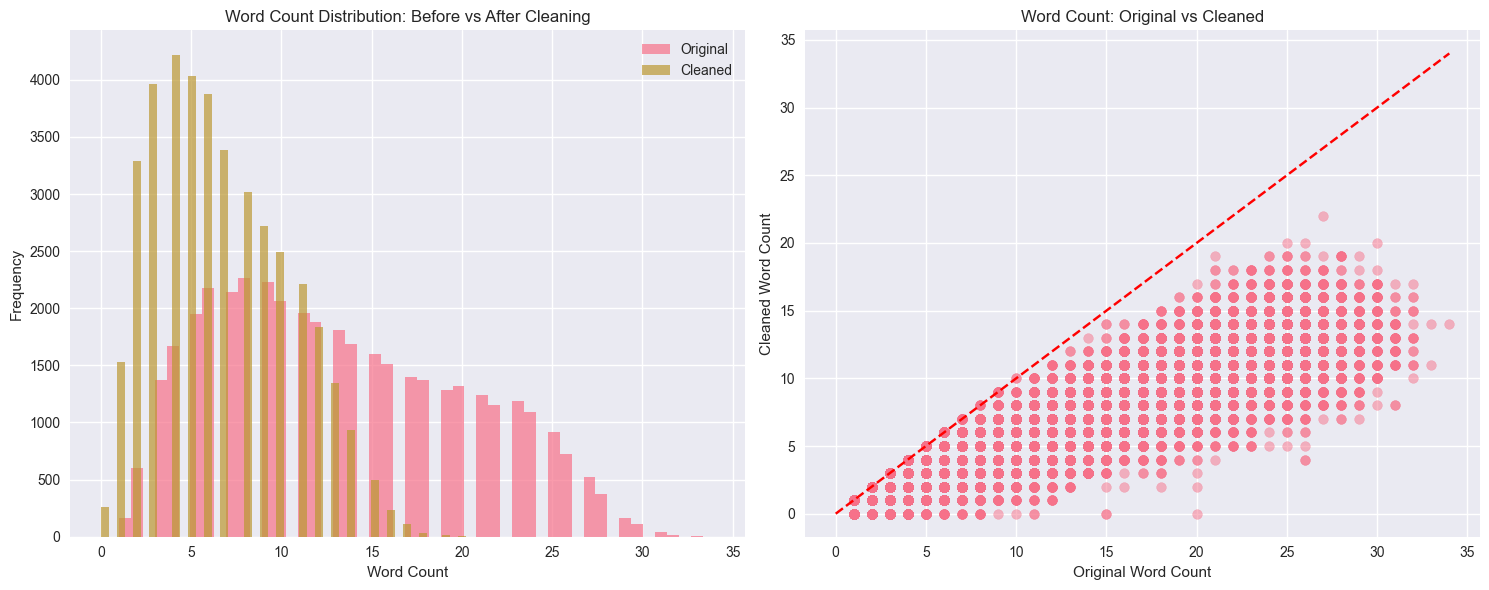

In [12]:
# Update text statistics after cleaning
sentiment_data['clean_text_length'] = sentiment_data['clean_content'].apply(len)
sentiment_data['clean_word_count'] = sentiment_data['clean_content'].apply(lambda x: len(str(x).split()))

# Compare before and after cleaning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(sentiment_data['word_count'], bins=50, alpha=0.7, label='Original')
ax1.hist(sentiment_data['clean_word_count'], bins=50, alpha=0.7, label='Cleaned')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Word Count Distribution: Before vs After Cleaning')
ax1.legend()

ax2.scatter(sentiment_data['word_count'], sentiment_data['clean_word_count'], alpha=0.5)
ax2.set_xlabel('Original Word Count')
ax2.set_ylabel('Cleaned Word Count')
ax2.set_title('Word Count: Original vs Cleaned')
ax2.plot([0, sentiment_data['word_count'].max()], [0, sentiment_data['word_count'].max()], 'r--')

plt.tight_layout()
plt.show()

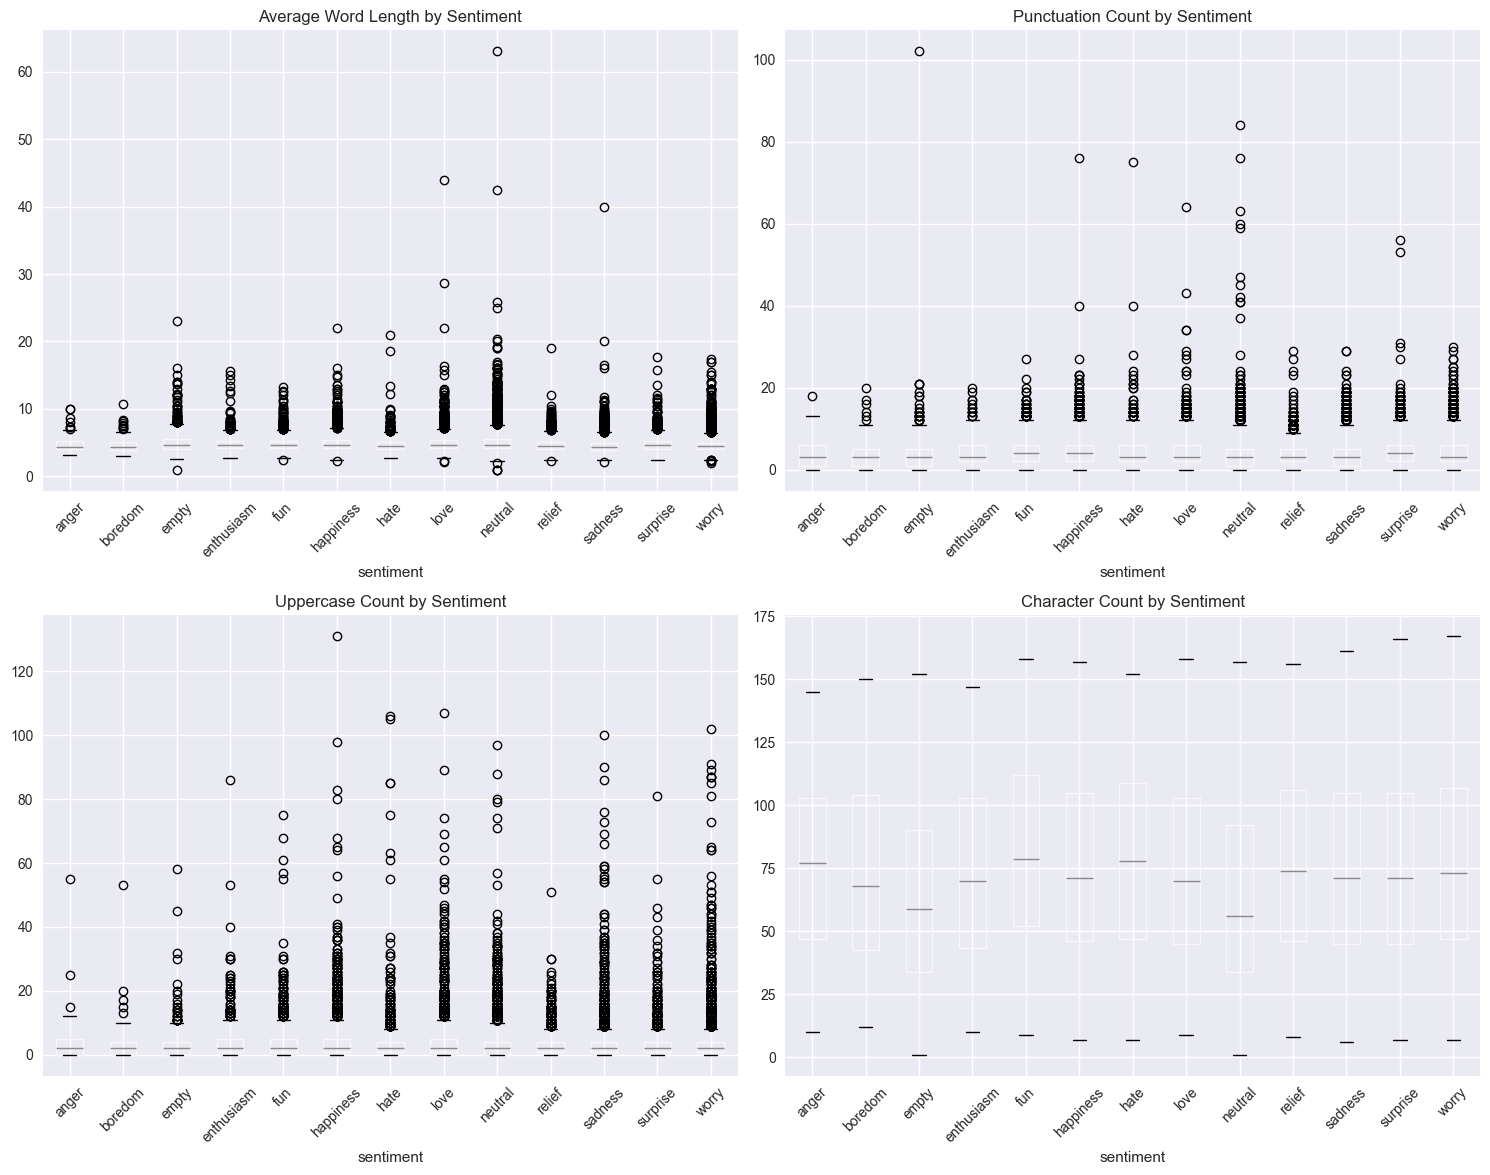

In [13]:
# Create additional features
sentiment_data['char_count'] = sentiment_data['content'].apply(len)
sentiment_data['avg_word_length'] = sentiment_data['content'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)
sentiment_data['punctuation_count'] = sentiment_data['content'].apply(
    lambda x: sum(1 for char in str(x) if char in string.punctuation)
)
sentiment_data['uppercase_count'] = sentiment_data['content'].apply(
    lambda x: sum(1 for char in str(x) if char.isupper())
)

# Visualize new features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Average word length by sentiment
sentiment_data.boxplot(column='avg_word_length', by='sentiment', ax=axes[0,0])
axes[0,0].set_title('Average Word Length by Sentiment')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

# Punctuation count by sentiment  
sentiment_data.boxplot(column='punctuation_count', by='sentiment', ax=axes[0,1])
axes[0,1].set_title('Punctuation Count by Sentiment')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

# Uppercase count by sentiment
sentiment_data.boxplot(column='uppercase_count', by='sentiment', ax=axes[1,0])
axes[1,0].set_title('Uppercase Count by Sentiment')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

# Character count by sentiment
sentiment_data.boxplot(column='char_count', by='sentiment', ax=axes[1,1])
axes[1,1].set_title('Character Count by Sentiment')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()

In [14]:
# Encode sentiment labels
le = LabelEncoder()
sentiment_data['sentiment_encoded'] = le.fit_transform(sentiment_data['sentiment'])

# Create mapping dictionary for later use
sentiment_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Sentiment mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment}: {code}")

Sentiment mapping:
anger: 0
boredom: 1
empty: 2
enthusiasm: 3
fun: 4
happiness: 5
hate: 6
love: 7
neutral: 8
relief: 9
sadness: 10
surprise: 11
worry: 12


In [15]:
# Prepare features and target
X = sentiment_data['clean_content']
y = sentiment_data['sentiment_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models and vectorizers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(class_weight='balanced', random_state=42)
}

vectorizers = {
    'TF-IDF (word)': TfidfVectorizer(max_features=5000, ngram_range=(1, 1)),
    'TF-IDF (word+bigram)': TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    'TF-IDF (word+bigram+trigram)': TfidfVectorizer(max_features=5000, ngram_range=(1, 3)),
    'Count (word)': CountVectorizer(max_features=5000, ngram_range=(1, 1)),
    'Count (word+bigram)': CountVectorizer(max_features=5000, ngram_range=(1, 2))
}

# Results storage
results = []

# Train and evaluate models
for vec_name, vectorizer in vectorizers.items():
    # Fit vectorizer
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train_vec, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_vec)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            'Vectorizer': vec_name,
            'Model': model_name,
            'Accuracy': accuracy
        })
        
        print(f"{vec_name} + {model_name}: {accuracy:.4f}")

# Convert results to dataframe
results_df = pd.DataFrame(results)

TF-IDF (word) + Logistic Regression: 0.2380
TF-IDF (word) + Random Forest: 0.3131
TF-IDF (word) + Naive Bayes: 0.3171
TF-IDF (word) + Linear SVM: 0.2391
TF-IDF (word+bigram) + Logistic Regression: 0.2416
TF-IDF (word+bigram) + Random Forest: 0.3095
TF-IDF (word+bigram) + Naive Bayes: 0.3206
TF-IDF (word+bigram) + Linear SVM: 0.2392
TF-IDF (word+bigram+trigram) + Logistic Regression: 0.2411
TF-IDF (word+bigram+trigram) + Random Forest: 0.3100
TF-IDF (word+bigram+trigram) + Naive Bayes: 0.3206
TF-IDF (word+bigram+trigram) + Linear SVM: 0.2357
Count (word) + Logistic Regression: 0.2504
Count (word) + Random Forest: 0.2742
Count (word) + Naive Bayes: 0.3300
Count (word) + Linear SVM: 0.2347
Count (word+bigram) + Logistic Regression: 0.2510
Count (word+bigram) + Random Forest: 0.2705
Count (word+bigram) + Naive Bayes: 0.3306
Count (word+bigram) + Linear SVM: 0.2387


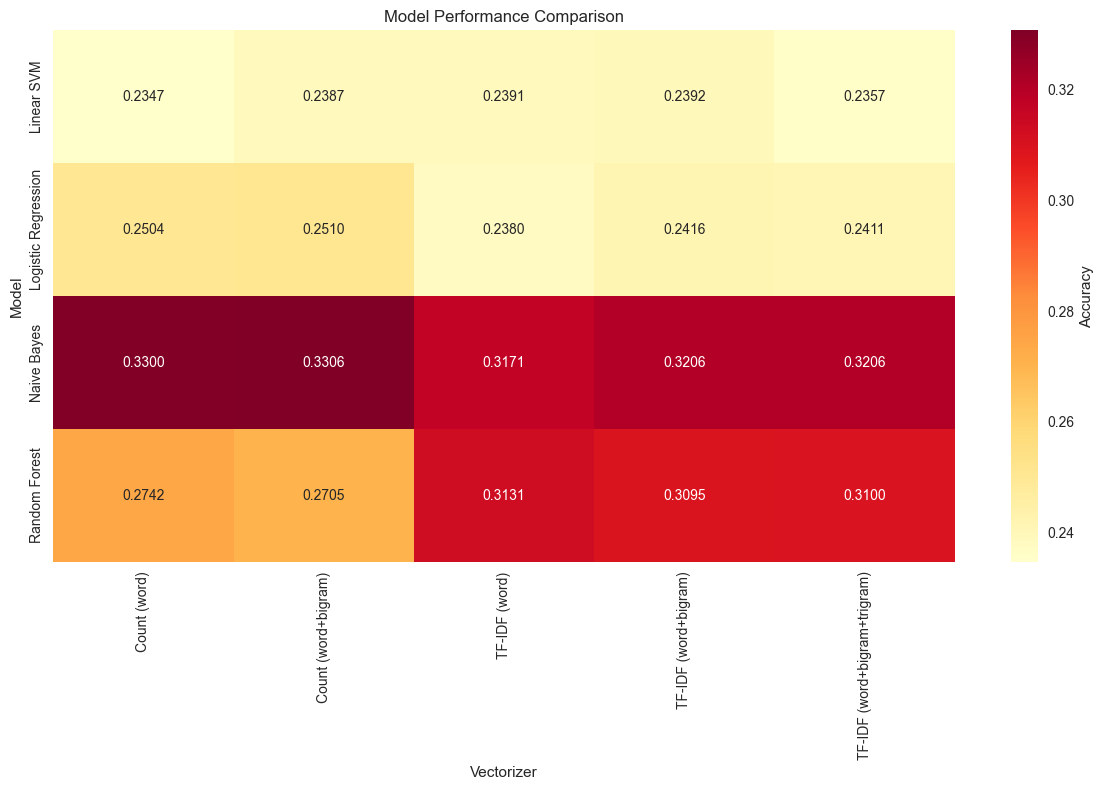

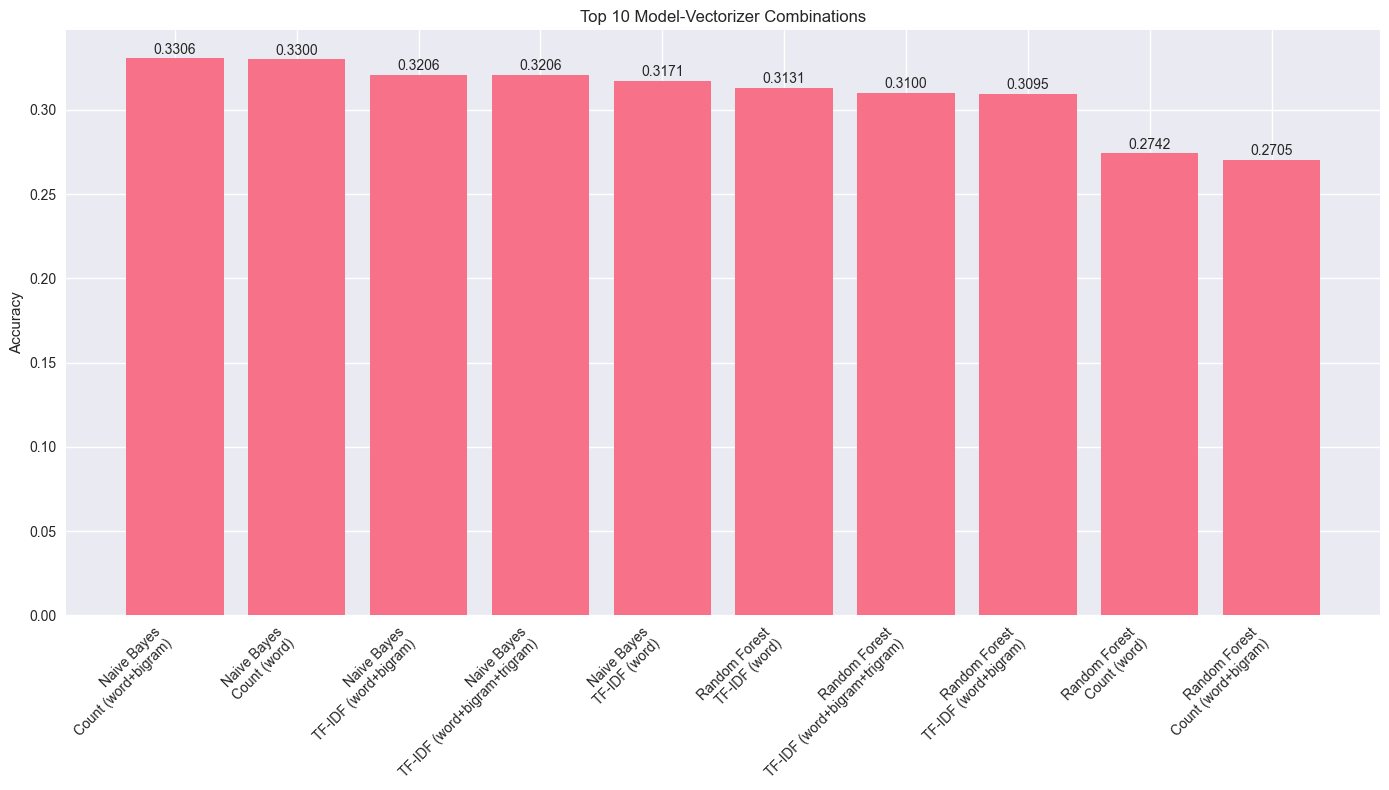

In [16]:
# Pivot the results for heatmap
pivot_results = results_df.pivot(index='Model', columns='Vectorizer', values='Accuracy')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_results, annot=True, cmap='YlOrRd', fmt='.4f', cbar_kws={'label': 'Accuracy'})
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

# Bar plot of best performing combinations
plt.figure(figsize=(14, 8))
top_10 = results_df.nlargest(10, 'Accuracy')
bars = plt.bar(range(len(top_10)), top_10['Accuracy'])
plt.xticks(range(len(top_10)), [f"{row['Model']}\n{row['Vectorizer']}" for _, row in top_10.iterrows()], 
           rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Top 10 Model-Vectorizer Combinations')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [17]:
# Get the best combination
best_combo = results_df.nlargest(1, 'Accuracy').iloc[0]
print(f"Best combination: {best_combo['Model']} with {best_combo['Vectorizer']}")

# Set up the best vectorizer
if 'TF-IDF' in best_combo['Vectorizer']:
    if 'trigram' in best_combo['Vectorizer']:
        best_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
    elif 'bigram' in best_combo['Vectorizer']:
        best_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    else:
        best_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
else:
    if 'bigram' in best_combo['Vectorizer']:
        best_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
    else:
        best_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 1))

# Transform data
X_train_best = best_vectorizer.fit_transform(X_train)
X_test_best = best_vectorizer.transform(X_test)

# Hyperparameter tuning for the best model
if best_combo['Model'] == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(max_iter=1000, class_weight='balanced')
elif best_combo['Model'] == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestClassifier(class_weight='balanced', random_state=42)
elif best_combo['Model'] == 'Linear SVM':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'loss': ['hinge', 'squared_hinge']
    }
    best_model = LinearSVC(class_weight='balanced', random_state=42)
else:  # Naive Bayes
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
    }
    best_model = MultinomialNB()

# Perform grid search
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_best, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best combination: Naive Bayes with Count (word+bigram)
Best parameters: {'alpha': 5.0}
Best cross-validation score: 0.3267


In [18]:
# Use the best model from grid search
final_model = grid_search.best_estimator_

# Make predictions
y_pred = final_model.predict(X_test_best)
y_pred_proba = final_model.predict_proba(X_test_best)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy: 0.3360

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.00      0.00      0.00       355
   happiness       0.35      0.38      0.36      1042
        hate       0.60      0.01      0.02       265
        love       0.52      0.35      0.42       768
     neutral       0.32      0.47      0.38      1728
      relief       0.60      0.01      0.02       305
     sadness       0.35      0.16      0.22      1033
    surprise       0.17      0.00      0.01       437
       worry       0.31      0.61      0.41      1692

    accuracy                           0.34      8000
   macro avg       0.25      0.15      0.14      8000
weighted avg       0.33      0.34      0.29      8000



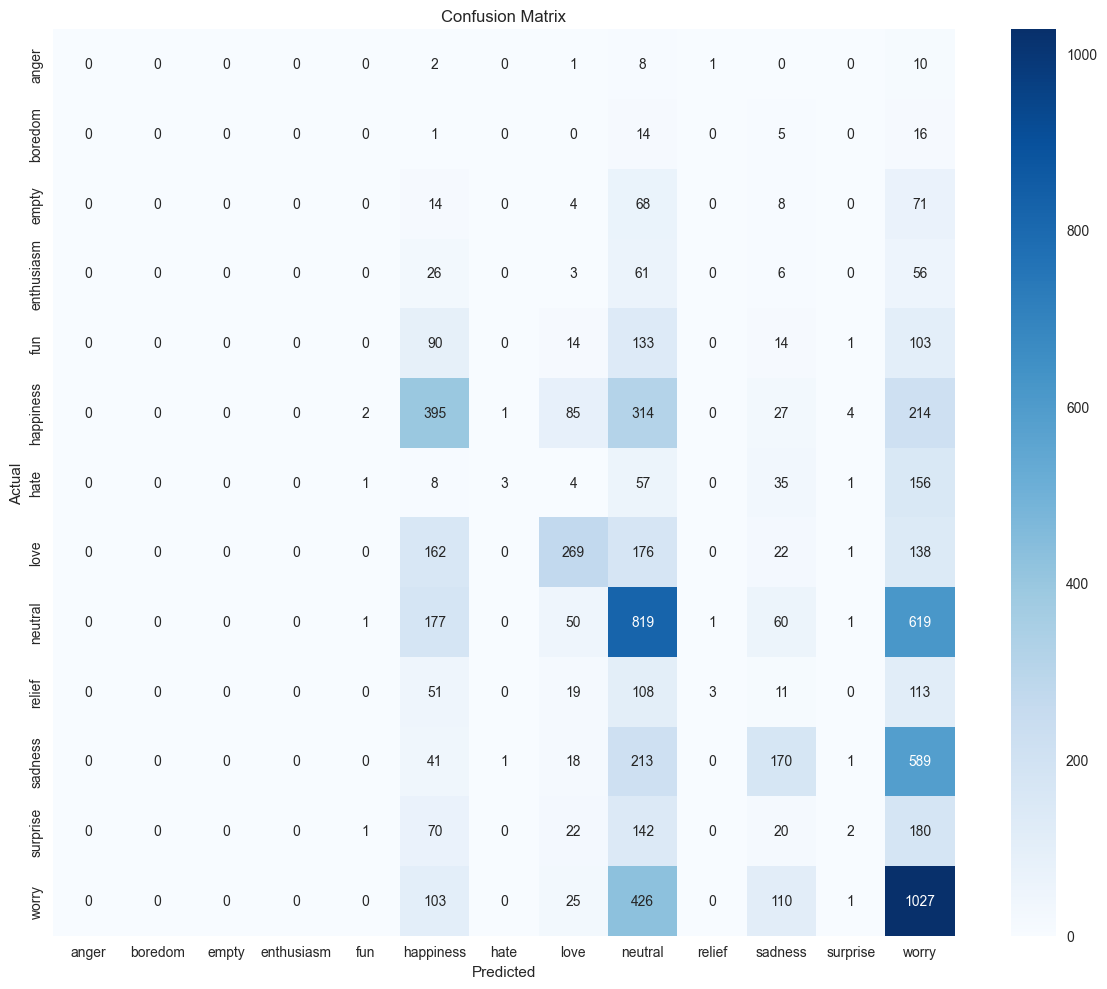

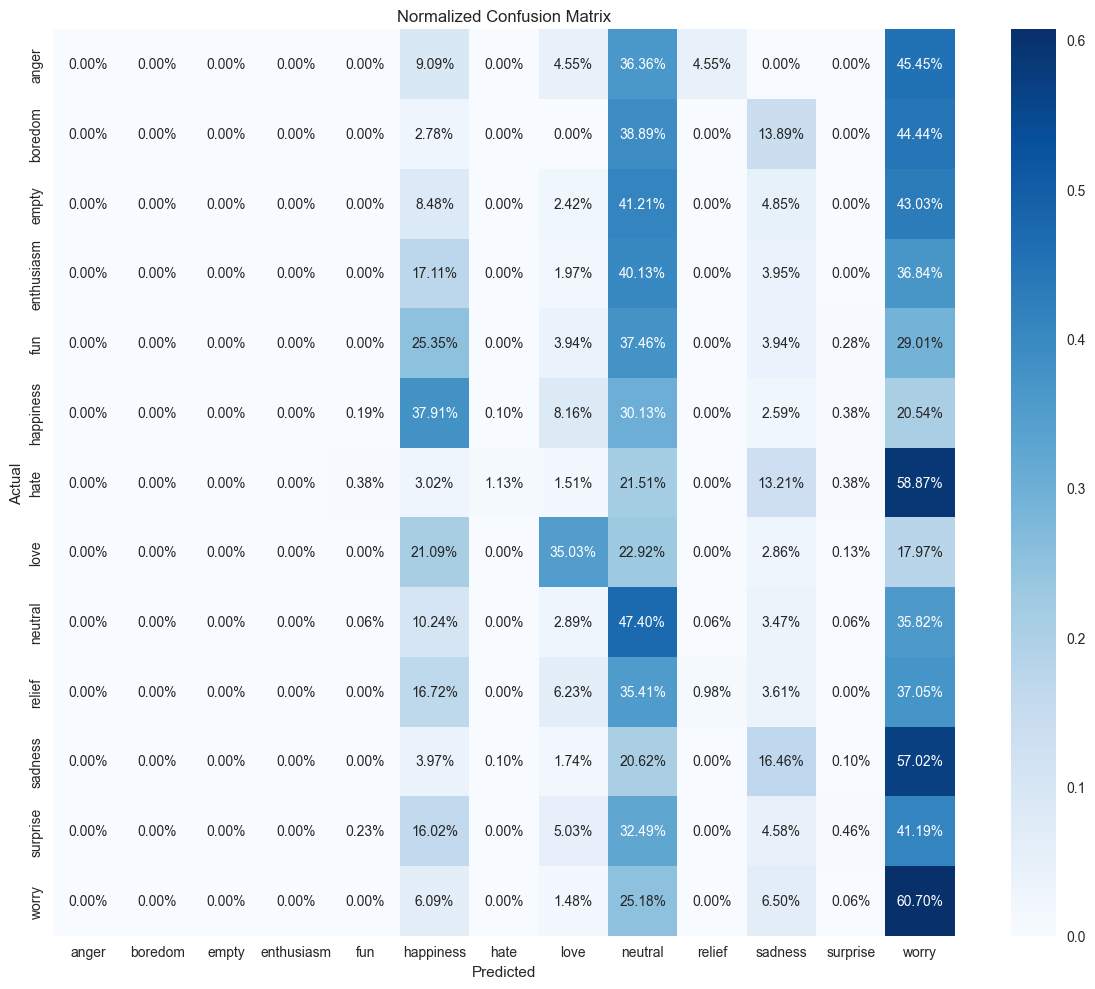

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
plt.figure(figsize=(12, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()